In [19]:
!pip install umap-learn


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import os

In [21]:
# שלב 1: קריאת הקובץ
file_path = "/content/drive/MyDrive/Ex2/IR-files/bert-sbert/sbert_vectors.csv"
data = pd.read_csv(file_path)

# בדיקה והצגה של הנתונים
print(data.head())
print()
print(data.info())
print()

# המרת עמודות הממדים (Dim0-Dim299) למטריצה
try:
    combined_matrix = data.loc[:, "Dim0":"Dim299"].to_numpy()  # כל העמודות מדימנסיה 0 עד 299
    print(f"Combined matrix shape: {combined_matrix.shape}")

    # שמירת עמודת Sheet כעמודת מטרה
    target_column = data['Sheet'].values
    print(f"Target column shape: {target_column.shape}")
except Exception as e:
    print(f"Error during conversion: {e}")


  Sheet  RowIndex      Dim0      Dim1      Dim2      Dim3      Dim4      Dim5  \
0   A-J         0  0.004812  0.026923  0.015163  0.007640 -0.012498  0.010280   
1   A-J         1  0.014052  0.029228  0.007936 -0.016101 -0.013189 -0.001558   
2   A-J         2  0.022085  0.010386  0.011578 -0.003908  0.006717 -0.004299   
3   A-J         3  0.014390  0.033544  0.001297 -0.012795  0.030116 -0.001583   
4   A-J         4  0.008542  0.048237 -0.007828 -0.007906 -0.001495 -0.015571   

       Dim6      Dim7  ...    Dim374    Dim375    Dim376    Dim377    Dim378  \
0  0.012724 -0.018092  ...  0.008701  0.016885  0.008800  0.008313  0.008201   
1 -0.003385 -0.022059  ...  0.021585 -0.000603 -0.018857 -0.014222 -0.011867   
2  0.003057 -0.019972  ...  0.012670 -0.010248 -0.031286 -0.005751  0.011272   
3  0.001665 -0.034225  ...  0.000973  0.007662 -0.006293  0.002391 -0.021095   
4 -0.003299 -0.019079  ...  0.004528  0.000808 -0.002086 -0.010071  0.007890   

     Dim379    Dim380    Dim381 

In [22]:
print(f"Example vector: {target_column}")  # הדפסת דוגמה לווקטור

print(f"Example vector: {combined_matrix[0]}")  # הדפסת דוגמה לווקטור

Example vector: ['A-J' 'A-J' 'A-J' ... 'NY-T' 'NY-T' 'NY-T']
Example vector: [ 4.81197471e-03  2.69228071e-02  1.51633136e-02  7.63997668e-03
 -1.24977576e-02  1.02798445e-02  1.27244778e-02 -1.80917438e-02
  1.43999113e-02 -1.96244325e-02 -1.41282314e-02  2.72852648e-02
 -1.33522637e-02  9.53762326e-03  1.65175535e-02 -7.00728782e-03
 -3.77526246e-02  2.32806075e-02  4.78260312e-03 -3.74033279e-03
 -3.91921494e-04  2.17443332e-02  2.02074107e-02  8.31426587e-03
 -1.75166931e-02  1.24461362e-02 -3.51557229e-03 -7.39658659e-04
  1.17390156e-02  4.86133667e-03  8.52295198e-03  4.36645607e-03
 -2.24667508e-02 -6.84534339e-03 -1.47599587e-02  3.17264125e-02
  5.12171537e-03  1.29103297e-02 -1.59108182e-04 -3.88923869e-03
  1.88565310e-02 -5.00836642e-03 -1.53002823e-02 -9.16804839e-03
  1.34921297e-02  4.49773204e-03 -1.32412268e-02  4.15439921e-04
  8.84891860e-03 -1.96260326e-02  1.00700241e-02 -1.96152572e-02
  5.65595506e-03 -1.72534157e-02 -1.02970572e-02 -4.19863174e-03
  1.09190242e

In [23]:
# K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(combined_matrix)

# Silhouette Score
sil_score = silhouette_score(combined_matrix, kmeans_labels, metric='cosine')
print(f"Silhouette Score (K-Means): {sil_score}")

print(f"K-Means labels: {kmeans_labels}")

print(Counter(kmeans_labels))

Silhouette Score (K-Means): 0.05221516703954502
K-Means labels: [0 0 0 ... 0 2 2]
Counter({0: 2009, 2: 148, 3: 145, 1: 44})


In [24]:
# חישוב מטריצת מרחק (cosine)
distance_matrix = squareform(pdist(combined_matrix, metric='cosine'))

# חישוב MST (Minimum Spanning Tree) לצורך חישוב epsilon
mst = minimum_spanning_tree(distance_matrix).toarray()
epsilon = mst.max() if mst.max() > 0 else 0.5

print(f"Epsilon for DBSCAN: {epsilon}")

# DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=25, metric='cosine')
dbscan_labels = dbscan.fit_predict(combined_matrix)

# הצגת תוצאות DBSCAN
print(f"DBSCAN labels: {dbscan_labels}")

print(Counter(dbscan_labels))

Epsilon for DBSCAN: 0.684953253743639
DBSCAN labels: [0 0 0 ... 0 0 0]
Counter({0: 2345, -1: 1})


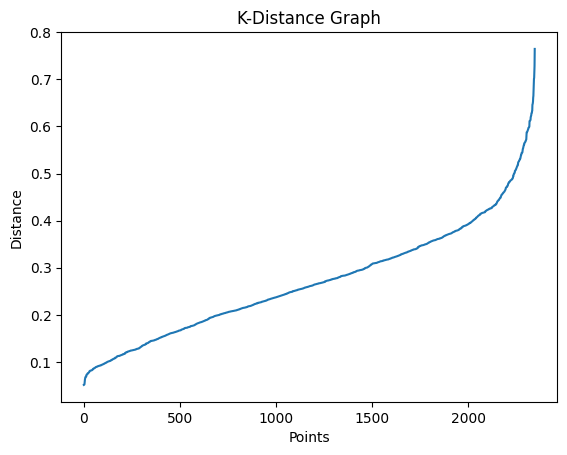

In [25]:
k = 5
nn = NearestNeighbors(n_neighbors=k, metric='cosine')
nn.fit(combined_matrix)
distances, indices = nn.kneighbors(combined_matrix)

# מיון המרחקים והצגה בגרף
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("K-Distance Graph")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()


In [26]:
# DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=15, metric='cosine') # קביעת האפסילון ע"פ הגרף שקיבלנו
dbscan_labels = dbscan.fit_predict(combined_matrix)

# הצגת תוצאות DBSCAN
print(f"DBSCAN labels: {dbscan_labels}")
print(Counter(dbscan_labels))

DBSCAN labels: [-1 -1 -1 ... -1 -1 -1]
Counter({-1: 1567, 2: 702, 1: 40, 0: 21, 3: 16})


In [27]:
# Mixture of Gaussians ע"י התפלגות גאוסיאנית
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(combined_matrix)

print(f"GMM labels: {gmm_labels}")
print(Counter(gmm_labels))

GMM labels: [0 0 0 ... 0 2 2]
Counter({0: 2009, 2: 148, 3: 145, 1: 44})


In [29]:
# tsne הורדה ל2 ממדים כדי לאפשר הצגה בגרף, תוך שמירה על יחסי הדמיון
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(combined_matrix)

# הצגת תוצאות ויזואליות עם K-Means
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("t-SNE Visualization with K-Means Clusters")
plt.colorbar(label='Cluster Label')
plt.show()

KeyboardInterrupt: 

In [ ]:
# תוצאות DBSCAN
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='plasma')
plt.title("t-SNE Visualization with DBSCAN Clusters")
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
# תוצאות GMM
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='coolwarm')
plt.title("t-SNE Visualization with GMM Clusters")
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
# המרה של target_column לערכים מספריים באמצעות LabelEncoder
label_encoder = LabelEncoder()
numeric_target = label_encoder.fit_transform(target_column)  # ממיר מחרוזות למספרים

# חישוב המדדים עבור K-Means
print("Evaluation Metrics for K-Means:")
print(f"Precision: {precision_score(numeric_target, kmeans_labels, average='weighted')}")
print(f"Recall: {recall_score(numeric_target, kmeans_labels, average='weighted')}")
print(f"F1 Score: {f1_score(numeric_target, kmeans_labels, average='weighted')}")
print(f"Accuracy: {accuracy_score(numeric_target, kmeans_labels)}")
print()

# חישוב המדדים עבור DBSCAN
print("Evaluation Metrics for DBSCAN:")
print(f"Precision: {precision_score(numeric_target, dbscan_labels, average='weighted', zero_division=1)}") # הוספת הזירו דיבישין = 1 כדי להתמודד עם קבוצת הרעשים שנוצרת בדיביסקאן
print(f"Recall: {recall_score(numeric_target, dbscan_labels, average='weighted', zero_division=1)}")
print(f"F1 Score: {f1_score(numeric_target, dbscan_labels, average='weighted', zero_division=1)}")
print(f"Accuracy: {accuracy_score(numeric_target, dbscan_labels)}")
print()

# חישוב המדדים עבור GMM
print("Evaluation Metrics for GMM:")
print(f"Precision: {precision_score(numeric_target, gmm_labels, average='weighted')}")
print(f"Recall: {recall_score(numeric_target, gmm_labels, average='weighted')}")
print(f"F1 Score: {f1_score(numeric_target, gmm_labels, average='weighted')}")
print(f"Accuracy: {accuracy_score(numeric_target, gmm_labels)}")

# **עד כאן חלק א של תרגיל 2**

In [30]:
# טעינת הנתונים ויצירת המטריצה ומערך הסיווגים
def load_and_preprocess_data(file_path):
    try:
        # טען את הנתונים
        data = pd.read_csv(file_path)

        # זיהוי עמודות הממדים באופן דינאמי
        dimension_columns = [col for col in data.columns if col.startswith("Dim")]
        print(f"Found {len(dimension_columns)} dimension columns.")

        # המרת עמודות הממדים למטריצה
        combined_matrix = data[dimension_columns].to_numpy()
        print(f"Combined matrix shape: {combined_matrix.shape}")

        # שמירת עמודת Sheet כעמודת מטרה (בודק אם קיימת)
        if 'Sheet' in data.columns:
            target_column = data['Sheet'].values
            print(f"Target column shape: {target_column.shape}")
        else:
            raise KeyError("'Sheet' column not found in the data!")

        return combined_matrix, target_column

    except Exception as e:
        print(f"Error during processing file {file_path}: {e}")
        return None, None

In [31]:
# אימון והערכת המודל
def train_and_evaluate_classical_models(X_train, X_test, y_train, y_test):
    """Trains and evaluates NB, SVM, LoR, RF models."""
    results = {}
    models = {
        'Naive Bayes': GaussianNB(),
        'SVM': SVC(kernel='linear', random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[model_name] = classification_report(y_test, y_pred, output_dict=True)
        print(f"Results for {model_name}:\n", classification_report(y_test, y_pred))
    return results

In [32]:
from sklearn.model_selection import KFold

def train_and_evaluate_ann(X, y, num_classes):
    """Trains and evaluates an Artificial Neural Network with 10-Fold Cross-Validation."""
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    plt.figure(figsize=(10, 6))  # Initialize a single figure for aggregated plots

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), start=1):
        print(f"Training on Fold {fold}...")

        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Define the ANN model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
            ModelCheckpoint(f"best_ann_model_fold_{fold}.keras", save_best_only=True)
        ]

        # Train the model
        history = model.fit(X_train, y_train,
                            epochs=15,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=0)

        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f"Fold {fold} Accuracy: {val_accuracy:.4f}")
        fold_accuracies.append(val_accuracy)

        # Plot training and validation accuracy for this fold
        plt.plot(history.history['accuracy'], label=f'Fold {fold} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'Fold {fold} Val Accuracy')

    # Show aggregated accuracy plot
    plt.title("ANN (ReLU) Training and Validation Accuracy Across Folds")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Compute average accuracy across folds
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy Across Folds: {avg_accuracy:.4f}")

    return {'accuracy': avg_accuracy, 'fold_accuracies': fold_accuracies}


In [33]:
from sklearn.model_selection import KFold

# Function to train and evaluate ANN with GELU activation and an embedding layer
def train_and_evaluate_ann_gelu(X, y, num_classes):
    """Trains and evaluates an Artificial Neural Network with GELU activation and 10-Fold Cross-Validation."""
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), start=1):
        print(f"Training on Fold {fold}...")

        # Splitting data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build ANN Model with GELU activation
        model = Sequential([
            Dense(64, activation='gelu'),
            Dense(32, activation='gelu'),
            Dense(16, activation='gelu'),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
            ModelCheckpoint(f"best_ann_fold_{fold}.keras", save_best_only=True)
        ]

        # Train model
        history = model.fit(X_train, y_train,
                            epochs=15,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=0)

        # Evaluate model
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f"Fold {fold} Accuracy: {val_accuracy:.4f}")
        fold_accuracies.append(val_accuracy)

        # Plotting training history
        plt.plot(history.history['accuracy'], label=f'Fold {fold} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'Fold {fold} Validation Accuracy')

    # Show aggregated accuracy plot
    plt.title("ANN Training History Across Folds")
    plt.legend()
    plt.show()

    # Average Accuracy
    avg_accuracy = np.mean(fold_accuracies)
    print(f"Average Accuracy Across Folds: {avg_accuracy:.4f}")

    return {'accuracy': avg_accuracy, 'fold_accuracies': fold_accuracies}

In [34]:
# הפונקציה הראשית, מזמנת את כל הפעולות לביצוע עבור כל מטריצה ומחזירה דאטה פריים של התוצאות
def main(file_path):
    print("Loading data...")
    combined_matrix, target_column = load_and_preprocess_data(file_path)

    # המרה של target_column לערכים מספריים באמצעות LabelEncoder
    label_encoder = LabelEncoder()
    numeric_target = label_encoder.fit_transform(target_column)  # ממיר מחרוזות למספרים

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(combined_matrix, numeric_target, test_size=0.2, random_state=42)

    print("Training classical models...")
    classical_results = train_and_evaluate_classical_models(X_train, X_test, y_train, y_test)

    print("Training ANN...")
    num_classes = len(np.unique(target_column))
    ann_results = train_and_evaluate_ann(combined_matrix, numeric_target, num_classes)

    print("Training ANN Gelu...")
    num_classes = len(np.unique(target_column))
    ann_gelu_results = train_and_evaluate_ann_gelu(combined_matrix, numeric_target, num_classes)

    # יצירת רשימה של שורות לתוצאה
    rows = []

    # הוספת תוצאות המודלים הקלאסיים
    for model_name, metrics in classical_results.items():
        for metric_name, metric_value in metrics.items():
            rows.append({"Model": model_name, "Metric": metric_name, "Value": metric_value})

    # הוספת תוצאות ה-ANN
    for metric_name, metric_value in ann_results.items():
        rows.append({"Model": "ANN", "Metric": metric_name, "Value": metric_value})

      # הוספת תוצאות ה-ANN
    for metric_name, metric_value in ann_gelu_results.items():
        rows.append({"Model": "ANN", "Metric": metric_name, "Value": metric_value})

    # יצירת DataFrame מכל השורות
    results = pd.DataFrame(rows)
    print("Results DataFrame created.")

    return results

In [35]:
# הרצת המיין עבור כל אחד מקבצי הנתונים
def process_files_in_folder(folder_path):
    # בדיקה אם התיקייה קיימת
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found!")
        return

    # עבור על כל התיקיות והקבצים בתיקייה ובתתי תיקיות
    for root, dirs, files in os.walk(folder_path):
        # מסנן רק קבצי CSV
        csv_files = [f for f in files if f.endswith('.csv')]

        print(f"Found {len(csv_files)} files to process in {root}.")

        for file_name in csv_files:
            try:
                # נתיב מלא לקובץ
                file_path = os.path.join(root, file_name)
                print(f"Processing file: {file_name}")

                # הרצת main על הקובץ
                results = main(file_path)

                # שמירת התוצאה כקובץ CSV חדש
                result_file_name = f"result_{file_name}"
                result_file_path = os.path.join(root, result_file_name)

                # שמירת תוצאות, בהנחה ש-main מחזירה pandas DataFrame
                results.to_csv(result_file_path, index=False)
                print(f"Results saved to: {result_file_name}")

            except Exception as e:
                print(f"Error processing file {file_name}: {e}")

Found 0 files to process in /content/drive/MyDrive/Ex2/IR-files.
Found 6 files to process in /content/drive/MyDrive/Ex2/IR-files/bert-sbert.
Processing file: bert_withIDF.csv
Loading data...
Found 768 dimension columns.
Combined matrix shape: (2346, 768)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       129
           1       0.67      0.90      0.77       100
           2       0.81      0.82      0.82       118
           3       0.76      0.59      0.66       123

    accuracy                           0.79       470
   macro avg       0.79      0.79      0.79       470
weighted avg       0.80      0.79      0.79       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       129
           1       0.95      0.97      0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.9787
Training on Fold 2...
Fold 2 Accuracy: 0.9745
Training on Fold 3...
Fold 3 Accuracy: 0.9745
Training on Fold 4...
Fold 4 Accuracy: 0.9915
Training on Fold 5...
Fold 5 Accuracy: 0.9830
Training on Fold 6...
Fold 6 Accuracy: 0.9915
Training on Fold 7...
Fold 7 Accuracy: 0.9744
Training on Fold 8...
Fold 8 Accuracy: 0.9744
Training on Fold 9...
Fold 9 Accuracy: 0.9829
Training on Fold 10...
Fold 10 Accuracy: 0.9957


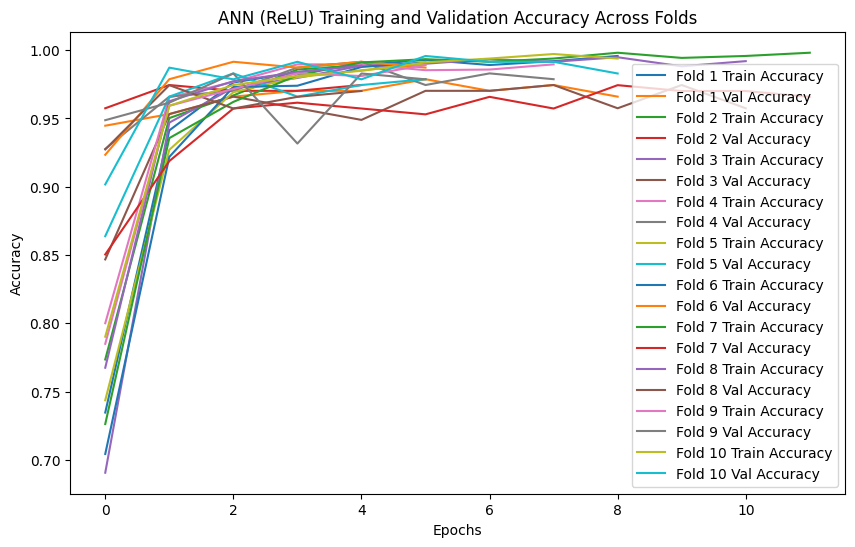

Average Accuracy Across Folds: 0.9821
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.9787
Training on Fold 2...
Fold 2 Accuracy: 0.9830
Training on Fold 3...
Fold 3 Accuracy: 0.9660
Training on Fold 4...
Fold 4 Accuracy: 0.9787
Training on Fold 5...
Fold 5 Accuracy: 0.9830
Training on Fold 6...
Fold 6 Accuracy: 0.9830
Training on Fold 7...
Fold 7 Accuracy: 0.9615
Training on Fold 8...
Fold 8 Accuracy: 0.9872
Training on Fold 9...
Fold 9 Accuracy: 0.9915
Training on Fold 10...
Fold 10 Accuracy: 0.9957


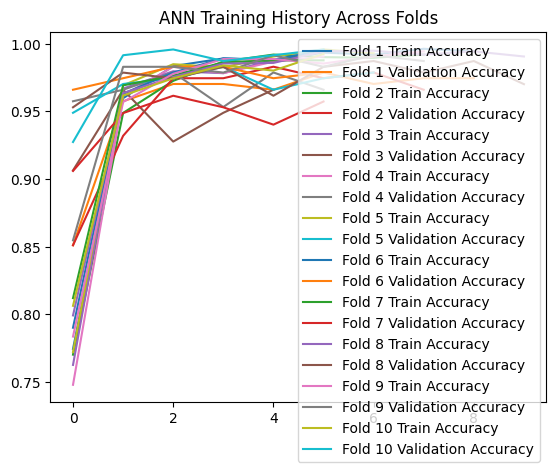

Average Accuracy Across Folds: 0.9808
Results DataFrame created.
Results saved to: result_bert_withIDF.csv
Processing file: sbert_vectors.csv
Loading data...
Found 384 dimension columns.
Combined matrix shape: (2346, 384)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86       129
           1       0.44      0.95      0.61       100
           2       0.72      0.33      0.45       118
           3       0.86      0.61      0.71       123

    accuracy                           0.67       470
   macro avg       0.74      0.68      0.66       470
weighted avg       0.75      0.67      0.67       470

Training SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Results for SVM:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       129
           1       0.00      0.00      0.00       100
           2       0.42      0.97      0.59       118
           3       1.00      0.57      0.73       123

    accuracy                           0.64       470
   macro avg       0.59      0.61      0.56       470
weighted avg       0.62      0.64      0.59       470

Training Logistic Regression...
Results for Logistic Regression:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       129
           1       0.46      0.85      0.60       100
           2       0.69      0.49      0.57       118
           3       0.87      0.56      0.68       123

    accuracy                           0.69       470
   macro avg       0.73      0.69      0.68       470
weighted avg       0.74      0.69      0.69       470

Training Random Forest...
Results for Random F

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.7617
Training on Fold 2...
Fold 2 Accuracy: 0.7064
Training on Fold 3...
Fold 3 Accuracy: 0.7745
Training on Fold 4...
Fold 4 Accuracy: 0.7447
Training on Fold 5...
Fold 5 Accuracy: 0.7489
Training on Fold 6...
Fold 6 Accuracy: 0.8894
Training on Fold 7...
Fold 7 Accuracy: 0.7393
Training on Fold 8...
Fold 8 Accuracy: 0.7265
Training on Fold 9...
Fold 9 Accuracy: 0.7735
Training on Fold 10...
Fold 10 Accuracy: 0.7094


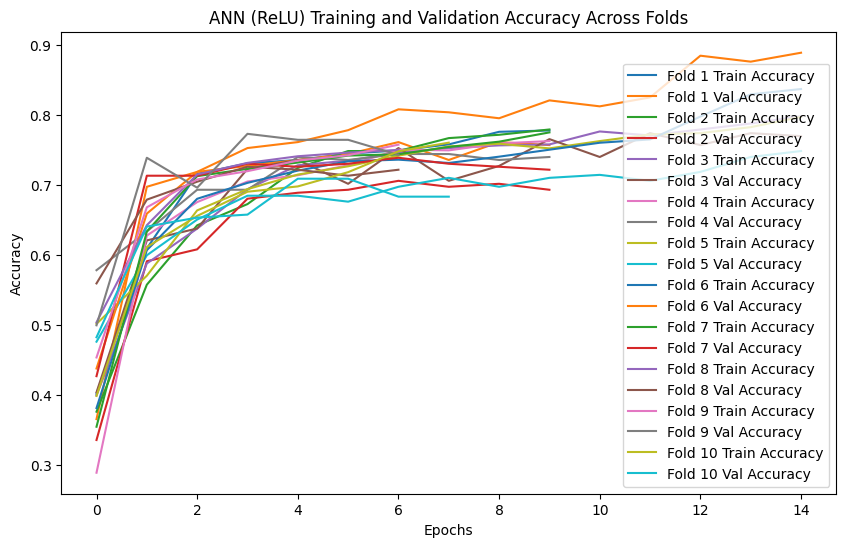

Average Accuracy Across Folds: 0.7574
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.7319
Training on Fold 2...
Fold 2 Accuracy: 0.7021
Training on Fold 3...
Fold 3 Accuracy: 0.7447
Training on Fold 4...
Fold 4 Accuracy: 0.7617
Training on Fold 5...
Fold 5 Accuracy: 0.7191
Training on Fold 6...
Fold 6 Accuracy: 0.8085
Training on Fold 7...
Fold 7 Accuracy: 0.7350
Training on Fold 8...
Fold 8 Accuracy: 0.7009
Training on Fold 9...
Fold 9 Accuracy: 0.7607
Training on Fold 10...
Fold 10 Accuracy: 0.6880


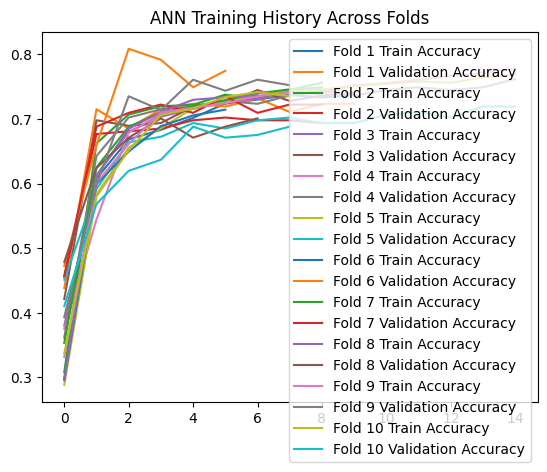

Average Accuracy Across Folds: 0.7353
Results DataFrame created.
Results saved to: result_sbert_vectors.csv
Processing file: bert_withoutIDF.csv
Loading data...
Found 768 dimension columns.
Combined matrix shape: (2346, 768)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       129
           1       0.73      0.94      0.82       100
           2       0.80      0.90      0.85       118
           3       0.83      0.63      0.71       123

    accuracy                           0.84       470
   macro avg       0.84      0.84      0.83       470
weighted avg       0.85      0.84      0.84       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       129
           1       0.94      0.99      0.97       100
           2     

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.9872
Training on Fold 2...
Fold 2 Accuracy: 0.9872
Training on Fold 3...
Fold 3 Accuracy: 0.9787
Training on Fold 4...
Fold 4 Accuracy: 0.9872
Training on Fold 5...
Fold 5 Accuracy: 0.9872
Training on Fold 6...
Fold 6 Accuracy: 0.9872
Training on Fold 7...
Fold 7 Accuracy: 0.9786
Training on Fold 8...
Fold 8 Accuracy: 0.9872
Training on Fold 9...
Fold 9 Accuracy: 0.9957
Training on Fold 10...
Fold 10 Accuracy: 0.9915


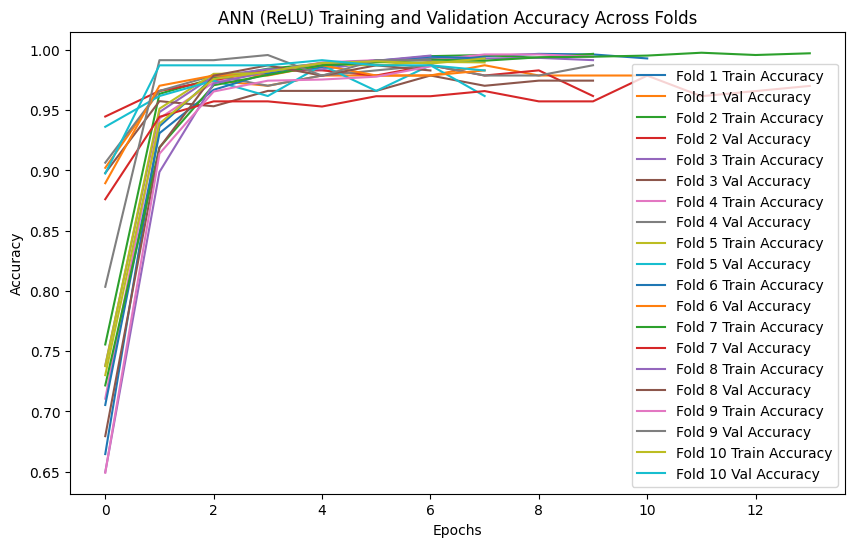

Average Accuracy Across Folds: 0.9868
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.9830
Training on Fold 2...
Fold 2 Accuracy: 0.9872
Training on Fold 3...
Fold 3 Accuracy: 0.9745
Training on Fold 4...
Fold 4 Accuracy: 0.9872
Training on Fold 5...
Fold 5 Accuracy: 0.9915
Training on Fold 6...
Fold 6 Accuracy: 0.9915
Training on Fold 7...
Fold 7 Accuracy: 0.9786
Training on Fold 8...
Fold 8 Accuracy: 0.9829
Training on Fold 9...
Fold 9 Accuracy: 0.9957
Training on Fold 10...
Fold 10 Accuracy: 0.9957


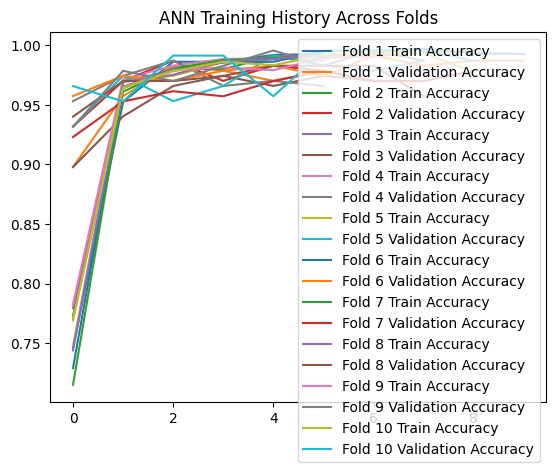

Average Accuracy Across Folds: 0.9868
Results DataFrame created.
Results saved to: result_bert_withoutIDF.csv
Processing file: result_bert_withIDF.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/bert-sbert/result_bert_withIDF.csv: "'Sheet' column not found in the data!"
Error processing file result_bert_withIDF.csv: y should be a 1d array, got an array of shape () instead.
Processing file: result_sbert_vectors.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/bert-sbert/result_sbert_vectors.csv: "'Sheet' column not found in the data!"
Error processing file result_sbert_vectors.csv: y should be a 1d array, got an array of shape () instead.
Processing file: result_bert_withoutIDF.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyD

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8809
Training on Fold 2...
Fold 2 Accuracy: 0.8511
Training on Fold 3...
Fold 3 Accuracy: 0.8213
Training on Fold 4...
Fold 4 Accuracy: 0.8468
Training on Fold 5...
Fold 5 Accuracy: 0.8638
Training on Fold 6...
Fold 6 Accuracy: 0.8723
Training on Fold 7...
Fold 7 Accuracy: 0.8462
Training on Fold 8...
Fold 8 Accuracy: 0.8761
Training on Fold 9...
Fold 9 Accuracy: 0.8889
Training on Fold 10...
Fold 10 Accuracy: 0.9145


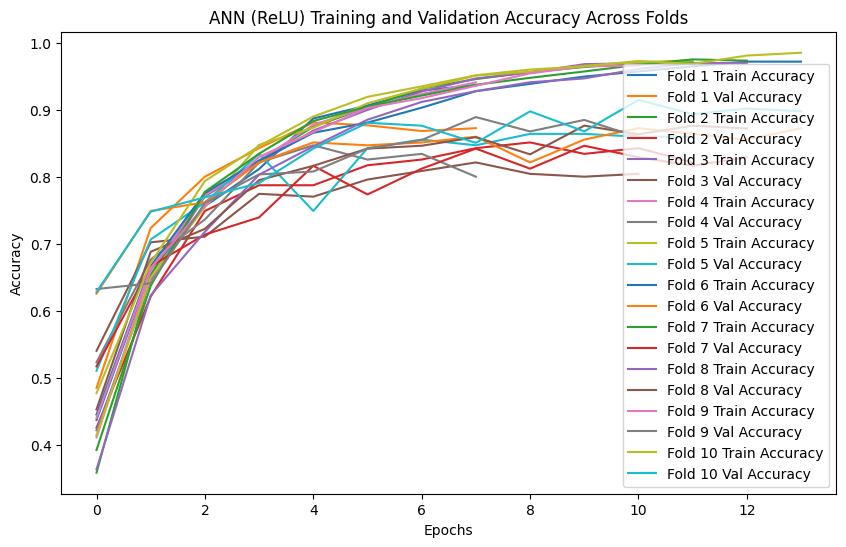

Average Accuracy Across Folds: 0.8662
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8553
Training on Fold 2...
Fold 2 Accuracy: 0.8170
Training on Fold 3...
Fold 3 Accuracy: 0.7830
Training on Fold 4...
Fold 4 Accuracy: 0.8128
Training on Fold 5...
Fold 5 Accuracy: 0.8851
Training on Fold 6...
Fold 6 Accuracy: 0.8468
Training on Fold 7...
Fold 7 Accuracy: 0.8205
Training on Fold 8...
Fold 8 Accuracy: 0.8376
Training on Fold 9...
Fold 9 Accuracy: 0.8803
Training on Fold 10...
Fold 10 Accuracy: 0.8462


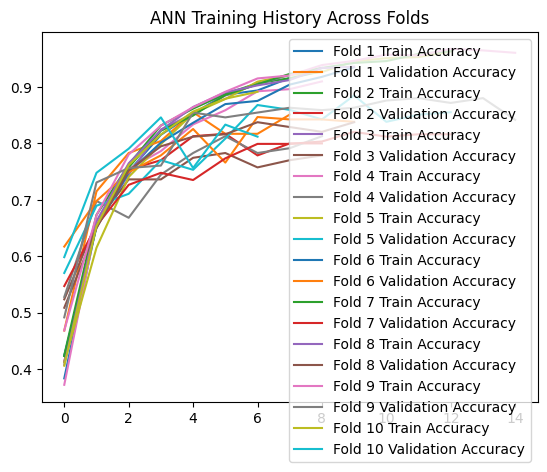

Average Accuracy Across Folds: 0.8385
Results DataFrame created.
Results saved to: result_w2v_clean_withIDF_withoutStopWords.csv
Processing file: w2v_lemma_withoutIdf_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       129
           1       0.61      0.83      0.71       100
           2       0.69      0.65      0.67       118
           3       0.82      0.61      0.70       123

    accuracy                           0.74       470
   macro avg       0.75      0.74      0.74       470
weighted avg       0.76      0.74      0.74       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.76      0.66      0.71       129
           1       0.65      0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.9021
Training on Fold 2...
Fold 2 Accuracy: 0.8511
Training on Fold 3...
Fold 3 Accuracy: 0.8638
Training on Fold 4...
Fold 4 Accuracy: 0.8511
Training on Fold 5...
Fold 5 Accuracy: 0.8809
Training on Fold 6...
Fold 6 Accuracy: 0.8809
Training on Fold 7...
Fold 7 Accuracy: 0.8419
Training on Fold 8...
Fold 8 Accuracy: 0.8547
Training on Fold 9...
Fold 9 Accuracy: 0.8974
Training on Fold 10...
Fold 10 Accuracy: 0.8974


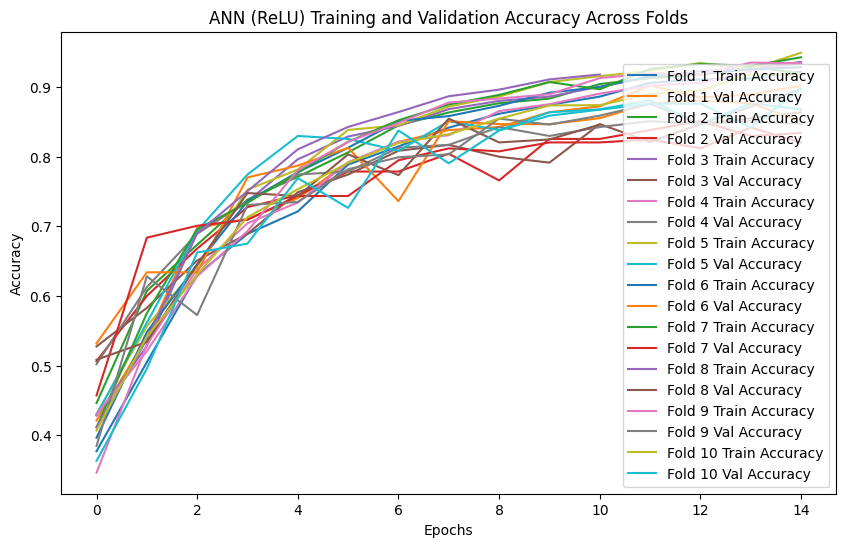

Average Accuracy Across Folds: 0.8721
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8851
Training on Fold 2...
Fold 2 Accuracy: 0.7915
Training on Fold 3...
Fold 3 Accuracy: 0.7872
Training on Fold 4...
Fold 4 Accuracy: 0.8894
Training on Fold 5...
Fold 5 Accuracy: 0.8638
Training on Fold 6...
Fold 6 Accuracy: 0.8170
Training on Fold 7...
Fold 7 Accuracy: 0.8120
Training on Fold 8...
Fold 8 Accuracy: 0.8333
Training on Fold 9...
Fold 9 Accuracy: 0.8590
Training on Fold 10...
Fold 10 Accuracy: 0.8803


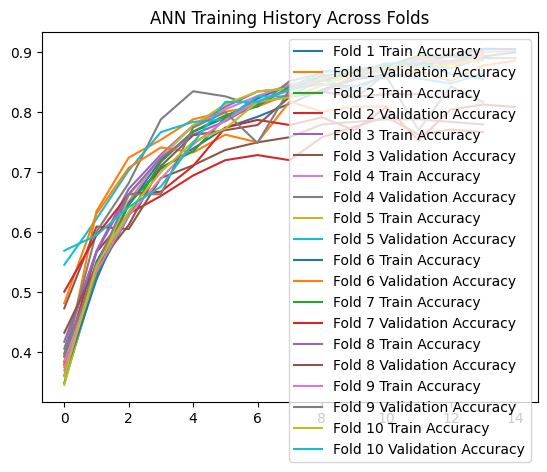

Average Accuracy Across Folds: 0.8419
Results DataFrame created.
Results saved to: result_w2v_lemma_withoutIdf_withStopWords.csv
Processing file: w2v_lemma_withoutIdf_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       129
           1       0.59      0.79      0.68       100
           2       0.68      0.66      0.67       118
           3       0.77      0.62      0.68       123

    accuracy                           0.73       470
   macro avg       0.73      0.73      0.72       470
weighted avg       0.74      0.73      0.73       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71       129
           1       0.66     

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8681
Training on Fold 2...
Fold 2 Accuracy: 0.8170
Training on Fold 3...
Fold 3 Accuracy: 0.8213
Training on Fold 4...
Fold 4 Accuracy: 0.8979
Training on Fold 5...
Fold 5 Accuracy: 0.8426
Training on Fold 6...
Fold 6 Accuracy: 0.8809
Training on Fold 7...
Fold 7 Accuracy: 0.8077
Training on Fold 8...
Fold 8 Accuracy: 0.8419
Training on Fold 9...
Fold 9 Accuracy: 0.8675
Training on Fold 10...
Fold 10 Accuracy: 0.9017


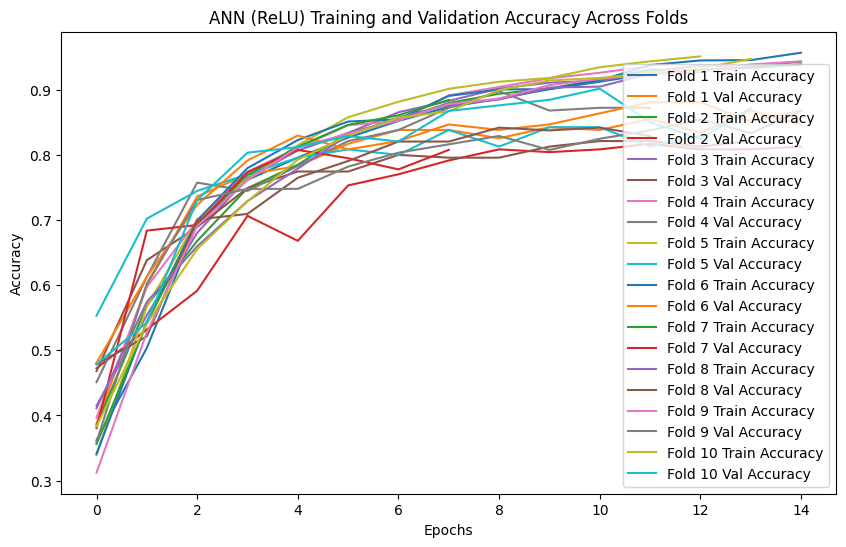

Average Accuracy Across Folds: 0.8546
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8255
Training on Fold 2...
Fold 2 Accuracy: 0.7660
Training on Fold 3...
Fold 3 Accuracy: 0.7574
Training on Fold 4...
Fold 4 Accuracy: 0.8681
Training on Fold 5...
Fold 5 Accuracy: 0.8128
Training on Fold 6...
Fold 6 Accuracy: 0.8511
Training on Fold 7...
Fold 7 Accuracy: 0.7521
Training on Fold 8...
Fold 8 Accuracy: 0.8333
Training on Fold 9...
Fold 9 Accuracy: 0.8120
Training on Fold 10...
Fold 10 Accuracy: 0.8291


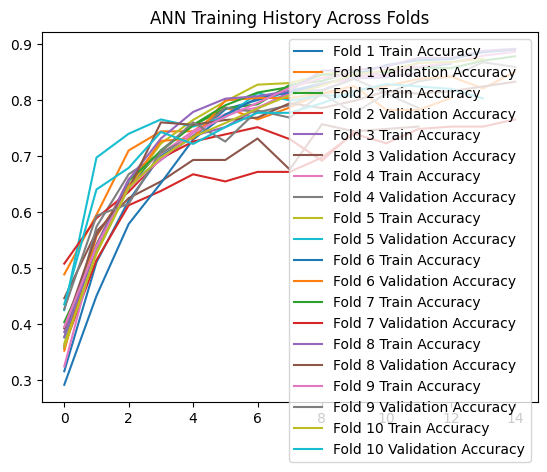

Average Accuracy Across Folds: 0.8107
Results DataFrame created.
Results saved to: result_w2v_lemma_withoutIdf_withoutStopWords.csv
Processing file: w2v_lemma_withIDF_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       129
           1       0.52      0.79      0.63       100
           2       0.53      0.47      0.50       118
           3       0.73      0.54      0.62       123

    accuracy                           0.61       470
   macro avg       0.62      0.61      0.60       470
weighted avg       0.62      0.61      0.60       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.70      0.66      0.68       129
           1       0.75      0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8681
Training on Fold 2...
Fold 2 Accuracy: 0.8170
Training on Fold 3...
Fold 3 Accuracy: 0.8468
Training on Fold 4...
Fold 4 Accuracy: 0.8255
Training on Fold 5...
Fold 5 Accuracy: 0.8596
Training on Fold 6...
Fold 6 Accuracy: 0.8085
Training on Fold 7...
Fold 7 Accuracy: 0.8376
Training on Fold 8...
Fold 8 Accuracy: 0.8462
Training on Fold 9...
Fold 9 Accuracy: 0.8504
Training on Fold 10...
Fold 10 Accuracy: 0.8504


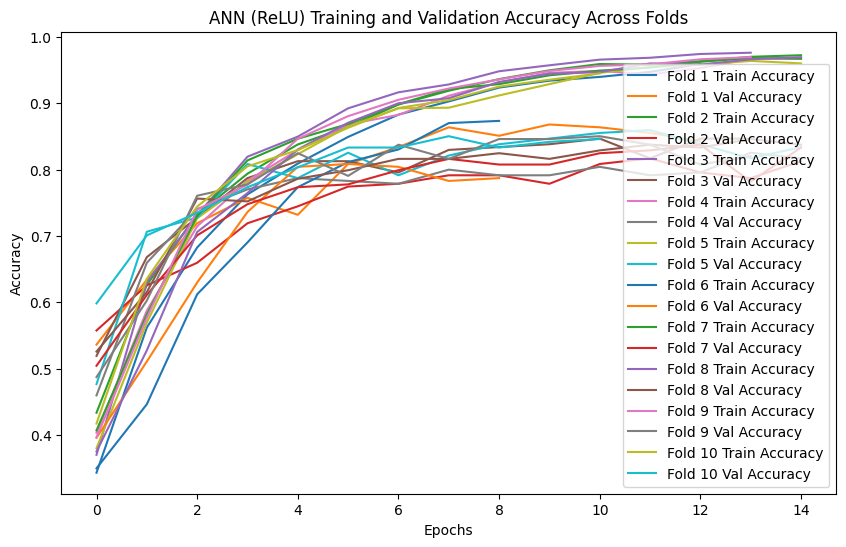

Average Accuracy Across Folds: 0.8410
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8553
Training on Fold 2...
Fold 2 Accuracy: 0.7660
Training on Fold 3...
Fold 3 Accuracy: 0.7872
Training on Fold 4...
Fold 4 Accuracy: 0.7915
Training on Fold 5...
Fold 5 Accuracy: 0.8340
Training on Fold 6...
Fold 6 Accuracy: 0.8383
Training on Fold 7...
Fold 7 Accuracy: 0.7607
Training on Fold 8...
Fold 8 Accuracy: 0.8291
Training on Fold 9...
Fold 9 Accuracy: 0.8504
Training on Fold 10...
Fold 10 Accuracy: 0.8761


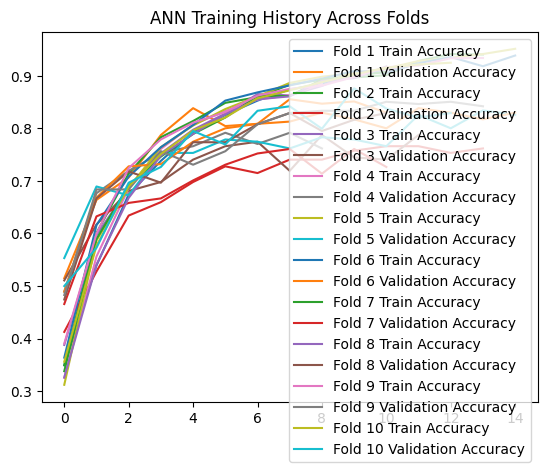

Average Accuracy Across Folds: 0.8189
Results DataFrame created.
Results saved to: result_w2v_lemma_withIDF_withStopWords.csv
Processing file: w2v_lemma_withIDF_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       129
           1       0.52      0.74      0.61       100
           2       0.54      0.51      0.52       118
           3       0.72      0.51      0.60       123

    accuracy                           0.61       470
   macro avg       0.62      0.61      0.61       470
weighted avg       0.62      0.61      0.61       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69       129
           1       0.75      0.90 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8468
Training on Fold 2...
Fold 2 Accuracy: 0.7957
Training on Fold 3...
Fold 3 Accuracy: 0.8170
Training on Fold 4...
Fold 4 Accuracy: 0.8170
Training on Fold 5...
Fold 5 Accuracy: 0.8511
Training on Fold 6...
Fold 6 Accuracy: 0.8426
Training on Fold 7...
Fold 7 Accuracy: 0.8419
Training on Fold 8...
Fold 8 Accuracy: 0.8333
Training on Fold 9...
Fold 9 Accuracy: 0.8419
Training on Fold 10...
Fold 10 Accuracy: 0.8504


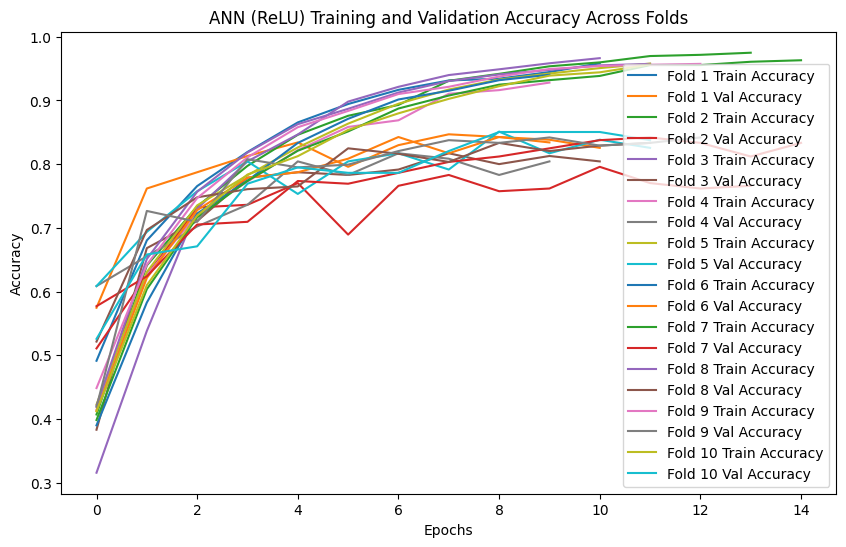

Average Accuracy Across Folds: 0.8338
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8340
Training on Fold 2...
Fold 2 Accuracy: 0.7617
Training on Fold 3...
Fold 3 Accuracy: 0.8000
Training on Fold 4...
Fold 4 Accuracy: 0.8340
Training on Fold 5...
Fold 5 Accuracy: 0.8340
Training on Fold 6...
Fold 6 Accuracy: 0.8298
Training on Fold 7...
Fold 7 Accuracy: 0.7991
Training on Fold 8...
Fold 8 Accuracy: 0.8376
Training on Fold 9...
Fold 9 Accuracy: 0.8419
Training on Fold 10...
Fold 10 Accuracy: 0.8248


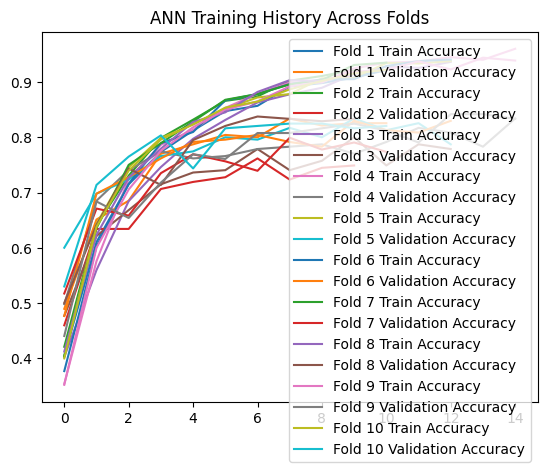

Average Accuracy Across Folds: 0.8197
Results DataFrame created.
Results saved to: result_w2v_lemma_withIDF_withoutStopWords.csv
Processing file: w2v_clean_withIDF_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72       129
           1       0.53      0.79      0.64       100
           2       0.53      0.49      0.51       118
           3       0.78      0.56      0.65       123

    accuracy                           0.63       470
   macro avg       0.64      0.64      0.63       470
weighted avg       0.65      0.63      0.63       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67       129
           1       0.79      0.95 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8723
Training on Fold 2...
Fold 2 Accuracy: 0.8426
Training on Fold 3...
Fold 3 Accuracy: 0.8426
Training on Fold 4...
Fold 4 Accuracy: 0.8851
Training on Fold 5...
Fold 5 Accuracy: 0.8851
Training on Fold 6...
Fold 6 Accuracy: 0.8723
Training on Fold 7...
Fold 7 Accuracy: 0.8547
Training on Fold 8...
Fold 8 Accuracy: 0.8932
Training on Fold 9...
Fold 9 Accuracy: 0.8761
Training on Fold 10...
Fold 10 Accuracy: 0.9060


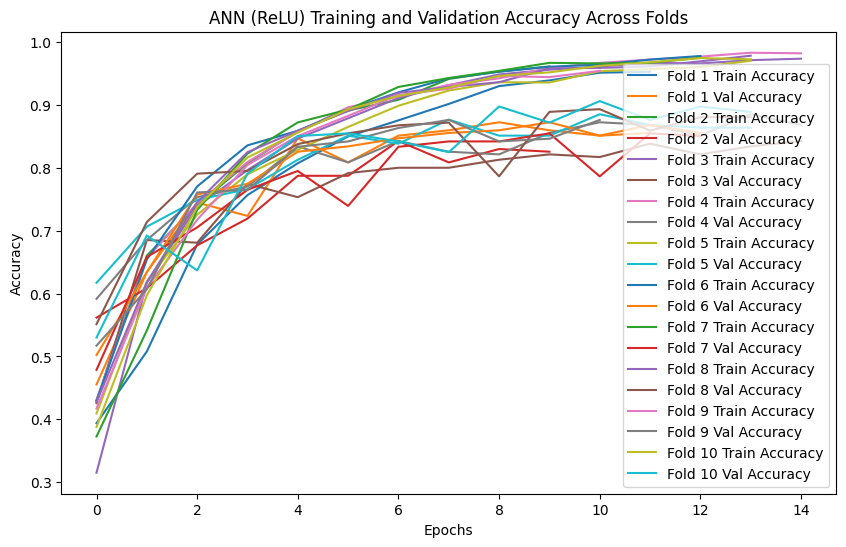

Average Accuracy Across Folds: 0.8730
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8723
Training on Fold 2...
Fold 2 Accuracy: 0.8255
Training on Fold 3...
Fold 3 Accuracy: 0.8000
Training on Fold 4...
Fold 4 Accuracy: 0.8426
Training on Fold 5...
Fold 5 Accuracy: 0.8383
Training on Fold 6...
Fold 6 Accuracy: 0.8468
Training on Fold 7...
Fold 7 Accuracy: 0.6752
Training on Fold 8...
Fold 8 Accuracy: 0.8547
Training on Fold 9...
Fold 9 Accuracy: 0.8675
Training on Fold 10...
Fold 10 Accuracy: 0.8248


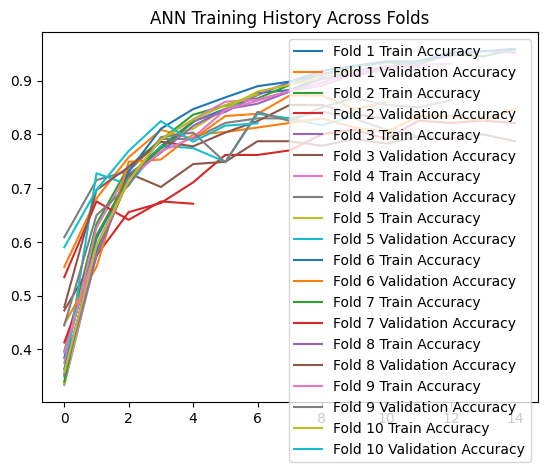

Average Accuracy Across Folds: 0.8248
Results DataFrame created.
Results saved to: result_w2v_clean_withIDF_withStopWords.csv
Processing file: w2v_clean_withoutIdf_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       129
           1       0.63      0.80      0.71       100
           2       0.66      0.69      0.67       118
           3       0.80      0.60      0.69       123

    accuracy                           0.74       470
   macro avg       0.74      0.74      0.73       470
weighted avg       0.75      0.74      0.74       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       129
           1       0.76      0.94 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.9021
Training on Fold 2...
Fold 2 Accuracy: 0.8851
Training on Fold 3...
Fold 3 Accuracy: 0.8638
Training on Fold 4...
Fold 4 Accuracy: 0.8638
Training on Fold 5...
Fold 5 Accuracy: 0.9021
Training on Fold 6...
Fold 6 Accuracy: 0.9106
Training on Fold 7...
Fold 7 Accuracy: 0.8462
Training on Fold 8...
Fold 8 Accuracy: 0.9145
Training on Fold 9...
Fold 9 Accuracy: 0.8462
Training on Fold 10...
Fold 10 Accuracy: 0.9145


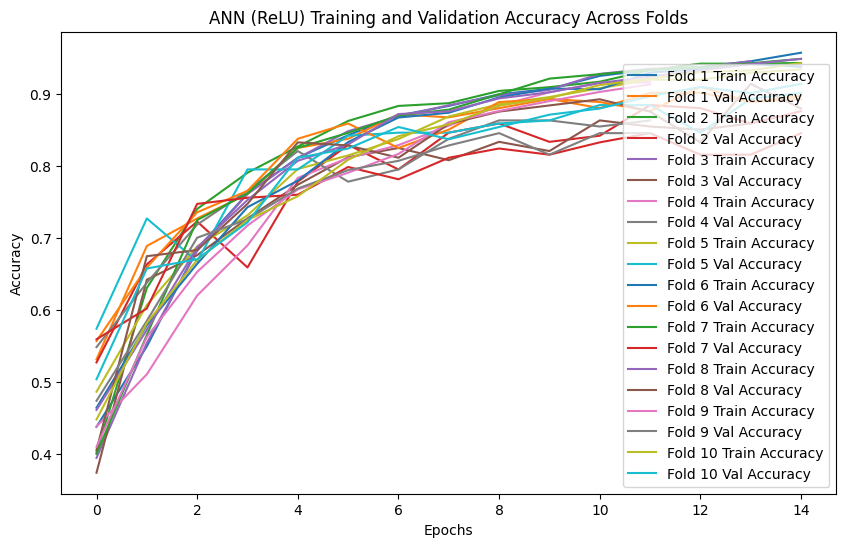

Average Accuracy Across Folds: 0.8849
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8638
Training on Fold 2...
Fold 2 Accuracy: 0.8511
Training on Fold 3...
Fold 3 Accuracy: 0.8298
Training on Fold 4...
Fold 4 Accuracy: 0.8596
Training on Fold 5...
Fold 5 Accuracy: 0.8723
Training on Fold 6...
Fold 6 Accuracy: 0.7915
Training on Fold 7...
Fold 7 Accuracy: 0.7949
Training on Fold 8...
Fold 8 Accuracy: 0.8504
Training on Fold 9...
Fold 9 Accuracy: 0.8632
Training on Fold 10...
Fold 10 Accuracy: 0.8974


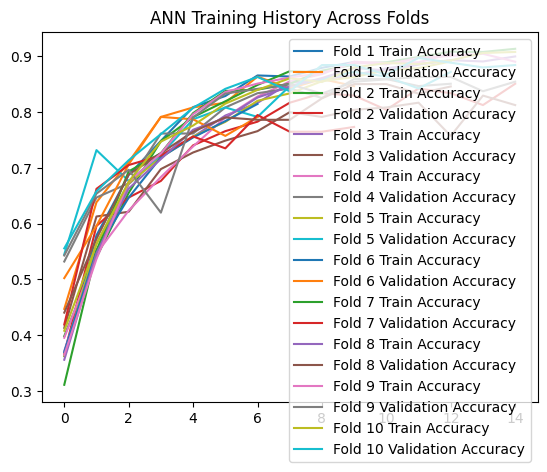

Average Accuracy Across Folds: 0.8474
Results DataFrame created.
Results saved to: result_w2v_clean_withoutIdf_withStopWords.csv
Processing file: w2v_clean_withoutIdf_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       129
           1       0.61      0.78      0.68       100
           2       0.67      0.67      0.67       118
           3       0.76      0.63      0.69       123

    accuracy                           0.73       470
   macro avg       0.74      0.73      0.73       470
weighted avg       0.74      0.73      0.74       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       129
           1       0.80     

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8979
Training on Fold 2...
Fold 2 Accuracy: 0.8553
Training on Fold 3...
Fold 3 Accuracy: 0.8468
Training on Fold 4...
Fold 4 Accuracy: 0.8766
Training on Fold 5...
Fold 5 Accuracy: 0.8723
Training on Fold 6...
Fold 6 Accuracy: 0.9021
Training on Fold 7...
Fold 7 Accuracy: 0.8419
Training on Fold 8...
Fold 8 Accuracy: 0.8590
Training on Fold 9...
Fold 9 Accuracy: 0.8803
Training on Fold 10...
Fold 10 Accuracy: 0.9103


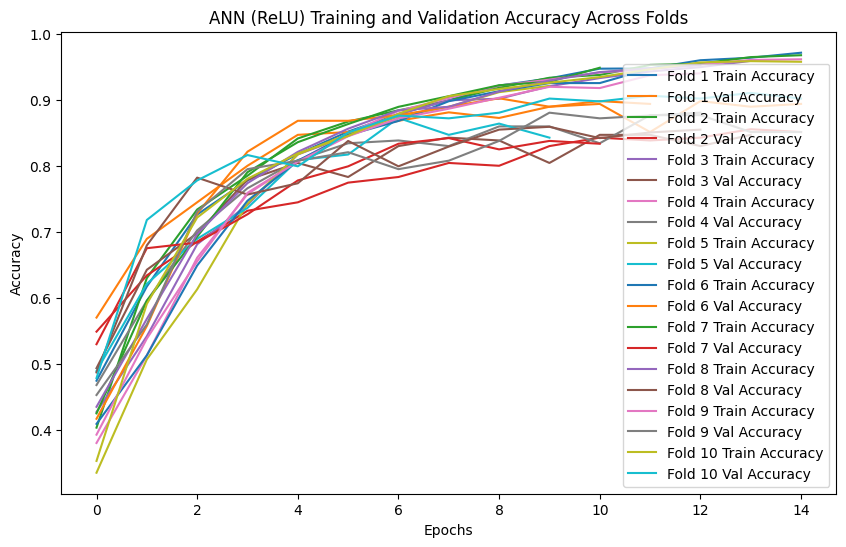

Average Accuracy Across Folds: 0.8743
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8723
Training on Fold 2...
Fold 2 Accuracy: 0.8085
Training on Fold 3...
Fold 3 Accuracy: 0.8128
Training on Fold 4...
Fold 4 Accuracy: 0.8383
Training on Fold 5...
Fold 5 Accuracy: 0.8638
Training on Fold 6...
Fold 6 Accuracy: 0.8681
Training on Fold 7...
Fold 7 Accuracy: 0.8120
Training on Fold 8...
Fold 8 Accuracy: 0.8547
Training on Fold 9...
Fold 9 Accuracy: 0.8504
Training on Fold 10...
Fold 10 Accuracy: 0.9103


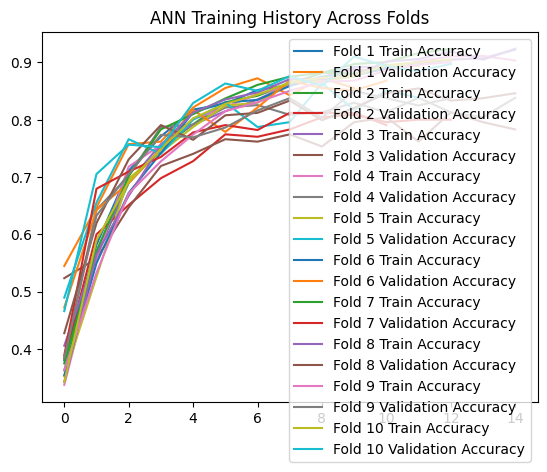

Average Accuracy Across Folds: 0.8491
Results DataFrame created.
Results saved to: result_w2v_clean_withoutIdf_withoutStopWords.csv
Processing file: result_w2v_clean_withIDF_withoutStopWords.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/word2vec/result_w2v_clean_withIDF_withoutStopWords.csv: "'Sheet' column not found in the data!"
Error processing file result_w2v_clean_withIDF_withoutStopWords.csv: y should be a 1d array, got an array of shape () instead.
Processing file: result_w2v_lemma_withoutIdf_withStopWords.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/word2vec/result_w2v_lemma_withoutIdf_withStopWords.csv: "'Sheet' column not found in the data!"
Error processing file result_w2v_lemma_withoutIdf_withStopWords.csv: y should be a 1d array, got an array of shape () instead.
Processing file: r

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.9191
Training on Fold 2...
Fold 2 Accuracy: 0.9489
Training on Fold 3...
Fold 3 Accuracy: 0.9447
Training on Fold 4...
Fold 4 Accuracy: 0.9234
Training on Fold 5...
Fold 5 Accuracy: 0.9277
Training on Fold 6...
Fold 6 Accuracy: 0.9447
Training on Fold 7...
Fold 7 Accuracy: 0.9316
Training on Fold 8...
Fold 8 Accuracy: 0.9359
Training on Fold 9...
Fold 9 Accuracy: 0.9188
Training on Fold 10...
Fold 10 Accuracy: 0.9444


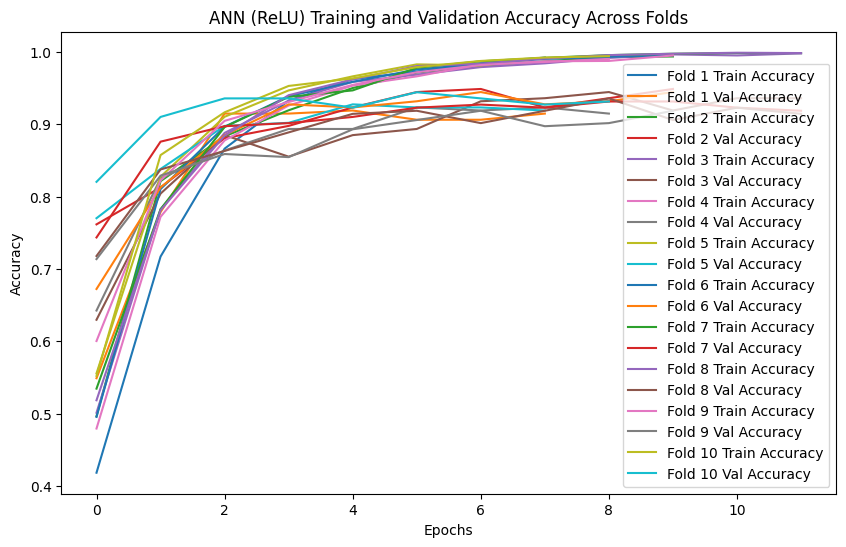

Average Accuracy Across Folds: 0.9339
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.9319
Training on Fold 2...
Fold 2 Accuracy: 0.9660
Training on Fold 3...
Fold 3 Accuracy: 0.9574
Training on Fold 4...
Fold 4 Accuracy: 0.9532
Training on Fold 5...
Fold 5 Accuracy: 0.9660
Training on Fold 6...
Fold 6 Accuracy: 0.9872
Training on Fold 7...
Fold 7 Accuracy: 0.9487
Training on Fold 8...
Fold 8 Accuracy: 0.9402
Training on Fold 9...
Fold 9 Accuracy: 0.9573
Training on Fold 10...
Fold 10 Accuracy: 0.9487


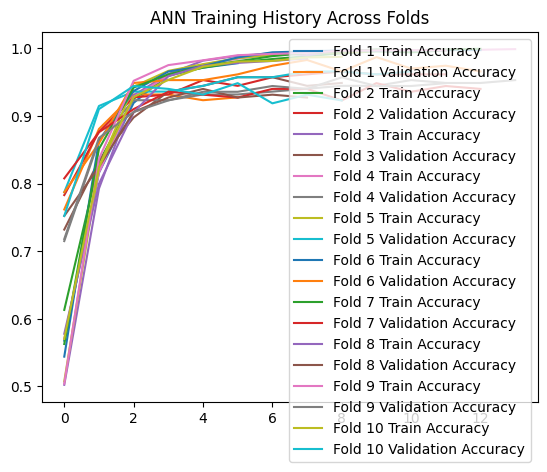

Average Accuracy Across Folds: 0.9557
Results DataFrame created.
Results saved to: result_doc2vec_vectors.csv
Processing file: result_doc2vec_vectors.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/doc2vec/result_doc2vec_vectors.csv: "'Sheet' column not found in the data!"
Error processing file result_doc2vec_vectors.csv: y should be a 1d array, got an array of shape () instead.
Found 0 files to process in /content/drive/MyDrive/Ex2/IR-files/TF-IDF.
Found 16 files to process in /content/drive/MyDrive/Ex2/IR-files/glove.
Processing file: glove_lemma_withIDF_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.63      0.53      0.57       129
      

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8255
Training on Fold 2...
Fold 2 Accuracy: 0.8085
Training on Fold 3...
Fold 3 Accuracy: 0.7702
Training on Fold 4...
Fold 4 Accuracy: 0.8340
Training on Fold 5...
Fold 5 Accuracy: 0.8553
Training on Fold 6...
Fold 6 Accuracy: 0.8340
Training on Fold 7...
Fold 7 Accuracy: 0.7991
Training on Fold 8...
Fold 8 Accuracy: 0.8504
Training on Fold 9...
Fold 9 Accuracy: 0.8547
Training on Fold 10...
Fold 10 Accuracy: 0.8333


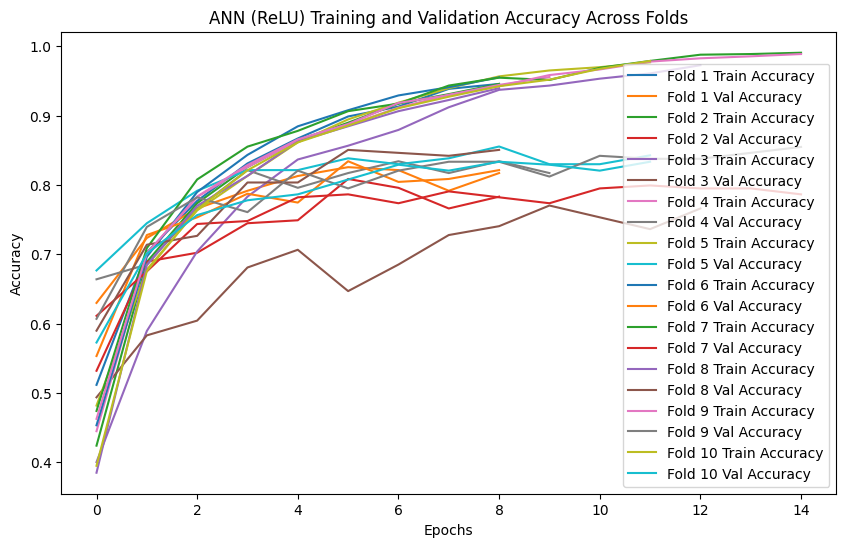

Average Accuracy Across Folds: 0.8265
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8468
Training on Fold 2...
Fold 2 Accuracy: 0.7745
Training on Fold 3...
Fold 3 Accuracy: 0.7830
Training on Fold 4...
Fold 4 Accuracy: 0.8213
Training on Fold 5...
Fold 5 Accuracy: 0.8766
Training on Fold 6...
Fold 6 Accuracy: 0.8426
Training on Fold 7...
Fold 7 Accuracy: 0.8034
Training on Fold 8...
Fold 8 Accuracy: 0.8504
Training on Fold 9...
Fold 9 Accuracy: 0.8590
Training on Fold 10...
Fold 10 Accuracy: 0.8205


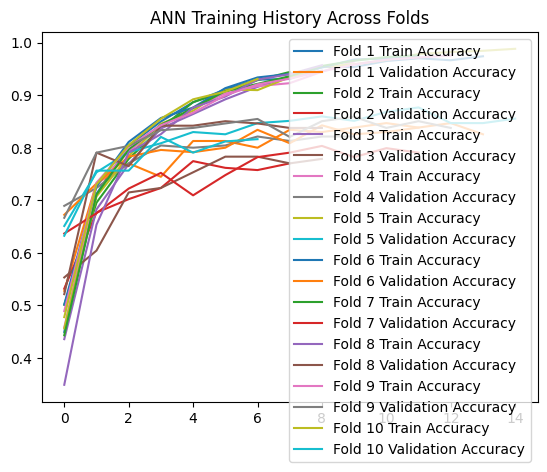

Average Accuracy Across Folds: 0.8278
Results DataFrame created.
Results saved to: result_glove_lemma_withIDF_withoutStopWords.csv
Processing file: glove_clean_withoutIdf_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85       129
           1       0.62      0.85      0.72       100
           2       0.68      0.68      0.68       118
           3       0.72      0.59      0.65       123

    accuracy                           0.73       470
   macro avg       0.73      0.73      0.72       470
weighted avg       0.74      0.73      0.73       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78       129
           1       0.87 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8979
Training on Fold 2...
Fold 2 Accuracy: 0.8681
Training on Fold 3...
Fold 3 Accuracy: 0.8553
Training on Fold 4...
Fold 4 Accuracy: 0.9021
Training on Fold 5...
Fold 5 Accuracy: 0.8766
Training on Fold 6...
Fold 6 Accuracy: 0.9064
Training on Fold 7...
Fold 7 Accuracy: 0.8803
Training on Fold 8...
Fold 8 Accuracy: 0.9145
Training on Fold 9...
Fold 9 Accuracy: 0.9103
Training on Fold 10...
Fold 10 Accuracy: 0.9188


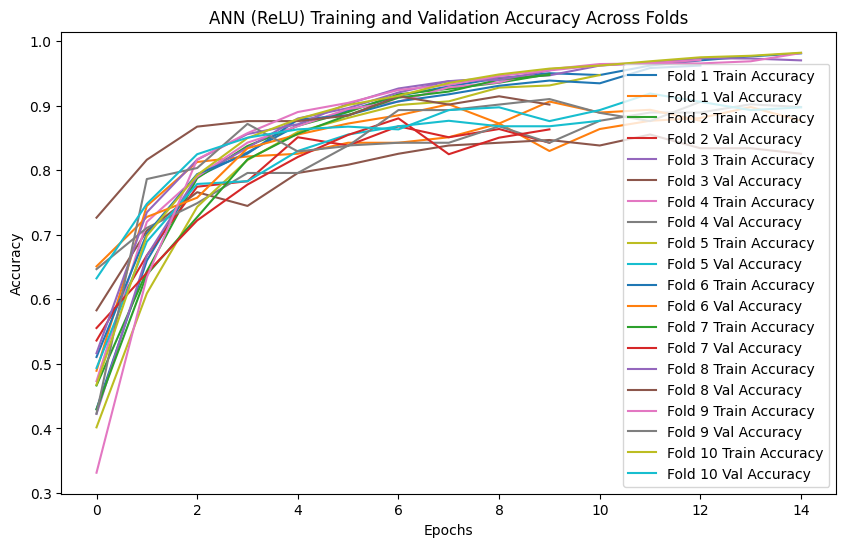

Average Accuracy Across Folds: 0.8930
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8468
Training on Fold 2...
Fold 2 Accuracy: 0.8426
Training on Fold 3...
Fold 3 Accuracy: 0.8553
Training on Fold 4...
Fold 4 Accuracy: 0.8766
Training on Fold 5...
Fold 5 Accuracy: 0.8723
Training on Fold 6...
Fold 6 Accuracy: 0.8979
Training on Fold 7...
Fold 7 Accuracy: 0.8761
Training on Fold 8...
Fold 8 Accuracy: 0.9188
Training on Fold 9...
Fold 9 Accuracy: 0.8803
Training on Fold 10...
Fold 10 Accuracy: 0.9145


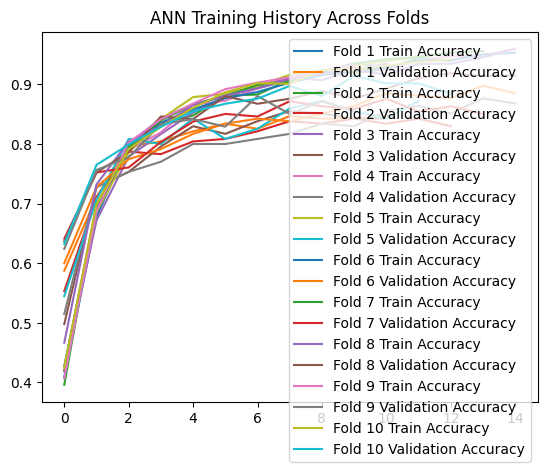

Average Accuracy Across Folds: 0.8781
Results DataFrame created.
Results saved to: result_glove_clean_withoutIdf_withoutStopWords.csv
Processing file: glove_clean_withIDF_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.69      0.66      0.67       129
           1       0.55      0.84      0.67       100
           2       0.56      0.50      0.53       118
           3       0.72      0.51      0.60       123

    accuracy                           0.62       470
   macro avg       0.63      0.63      0.62       470
weighted avg       0.63      0.62      0.61       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68       129
           1       0.78    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8851
Training on Fold 2...
Fold 2 Accuracy: 0.8298
Training on Fold 3...
Fold 3 Accuracy: 0.8000
Training on Fold 4...
Fold 4 Accuracy: 0.8340
Training on Fold 5...
Fold 5 Accuracy: 0.8851
Training on Fold 6...
Fold 6 Accuracy: 0.8298
Training on Fold 7...
Fold 7 Accuracy: 0.8504
Training on Fold 8...
Fold 8 Accuracy: 0.8590
Training on Fold 9...
Fold 9 Accuracy: 0.8974
Training on Fold 10...
Fold 10 Accuracy: 0.8675


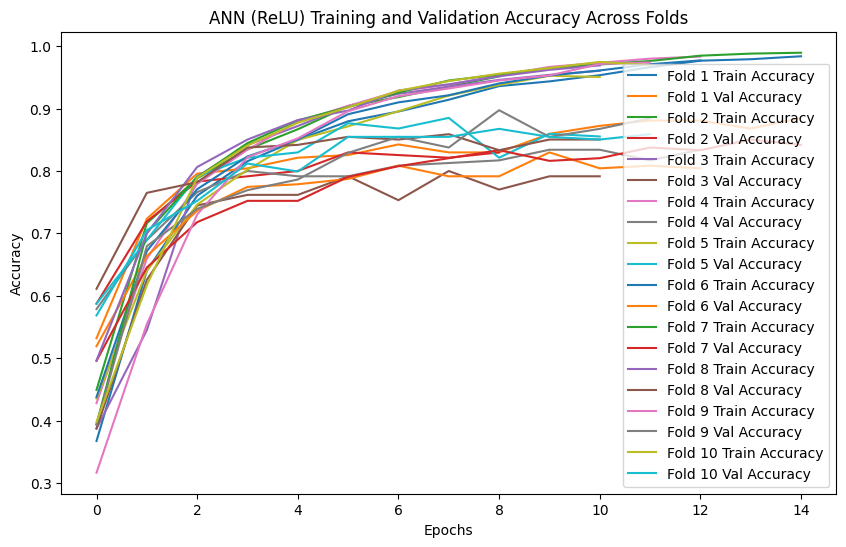

Average Accuracy Across Folds: 0.8538
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8723
Training on Fold 2...
Fold 2 Accuracy: 0.8340
Training on Fold 3...
Fold 3 Accuracy: 0.7745
Training on Fold 4...
Fold 4 Accuracy: 0.8298
Training on Fold 5...
Fold 5 Accuracy: 0.8553
Training on Fold 6...
Fold 6 Accuracy: 0.8298
Training on Fold 7...
Fold 7 Accuracy: 0.8547
Training on Fold 8...
Fold 8 Accuracy: 0.8675
Training on Fold 9...
Fold 9 Accuracy: 0.8675
Training on Fold 10...
Fold 10 Accuracy: 0.8462


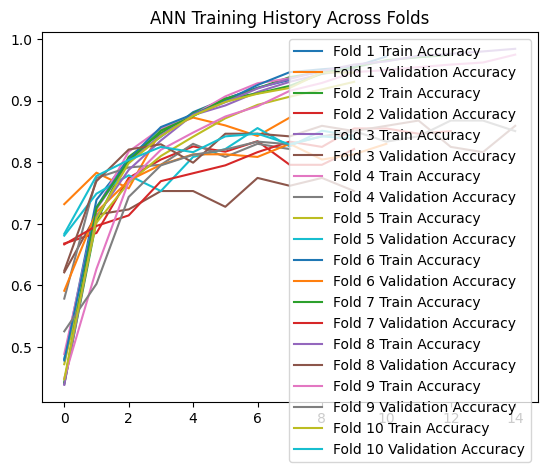

Average Accuracy Across Folds: 0.8432
Results DataFrame created.
Results saved to: result_glove_clean_withIDF_withStopWords.csv
Processing file: glove_lemma_withoutIdf_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82       129
           1       0.61      0.83      0.70       100
           2       0.66      0.64      0.65       118
           3       0.73      0.59      0.65       123

    accuracy                           0.71       470
   macro avg       0.71      0.71      0.71       470
weighted avg       0.72      0.71      0.71       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73       129
           1       0.82    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8511
Training on Fold 2...
Fold 2 Accuracy: 0.7957
Training on Fold 3...
Fold 3 Accuracy: 0.8255
Training on Fold 4...
Fold 4 Accuracy: 0.8596
Training on Fold 5...
Fold 5 Accuracy: 0.8979
Training on Fold 6...
Fold 6 Accuracy: 0.8723
Training on Fold 7...
Fold 7 Accuracy: 0.8462
Training on Fold 8...
Fold 8 Accuracy: 0.8675
Training on Fold 9...
Fold 9 Accuracy: 0.8248
Training on Fold 10...
Fold 10 Accuracy: 0.9145


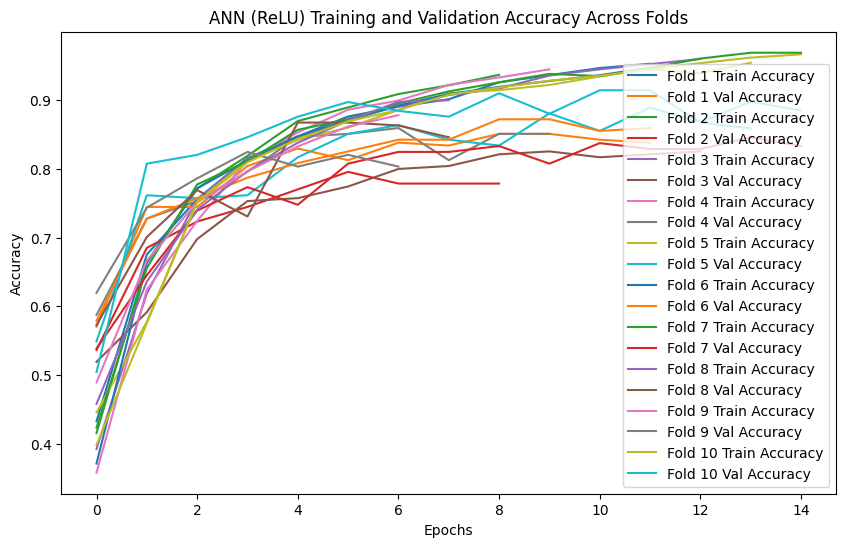

Average Accuracy Across Folds: 0.8555
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.7957
Training on Fold 2...
Fold 2 Accuracy: 0.8085
Training on Fold 3...
Fold 3 Accuracy: 0.7702
Training on Fold 4...
Fold 4 Accuracy: 0.8426
Training on Fold 5...
Fold 5 Accuracy: 0.8340
Training on Fold 6...
Fold 6 Accuracy: 0.8681
Training on Fold 7...
Fold 7 Accuracy: 0.8248
Training on Fold 8...
Fold 8 Accuracy: 0.8974
Training on Fold 9...
Fold 9 Accuracy: 0.8632
Training on Fold 10...
Fold 10 Accuracy: 0.8504


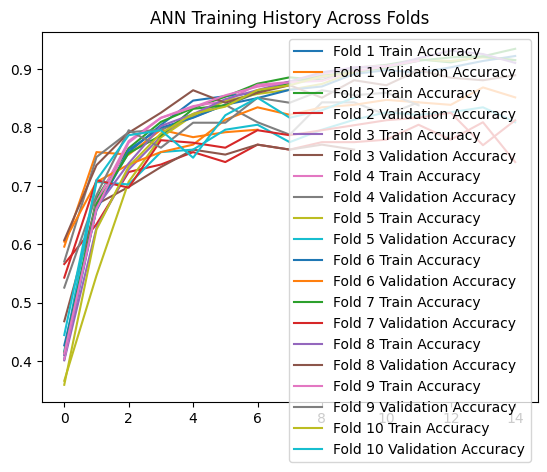

Average Accuracy Across Folds: 0.8355
Results DataFrame created.
Results saved to: result_glove_lemma_withoutIdf_withoutStopWords.csv
Processing file: glove_clean_withIDF_withoutStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.66      0.55      0.60       129
           1       0.54      0.82      0.65       100
           2       0.56      0.55      0.55       118
           3       0.63      0.49      0.55       123

    accuracy                           0.59       470
   macro avg       0.60      0.60      0.59       470
weighted avg       0.60      0.59      0.59       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.68      0.71      0.69       129
           1       0.83 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8383
Training on Fold 2...
Fold 2 Accuracy: 0.8383
Training on Fold 3...
Fold 3 Accuracy: 0.8170
Training on Fold 4...
Fold 4 Accuracy: 0.8426
Training on Fold 5...
Fold 5 Accuracy: 0.8936
Training on Fold 6...
Fold 6 Accuracy: 0.8170
Training on Fold 7...
Fold 7 Accuracy: 0.8248
Training on Fold 8...
Fold 8 Accuracy: 0.8632
Training on Fold 9...
Fold 9 Accuracy: 0.8974
Training on Fold 10...
Fold 10 Accuracy: 0.8632


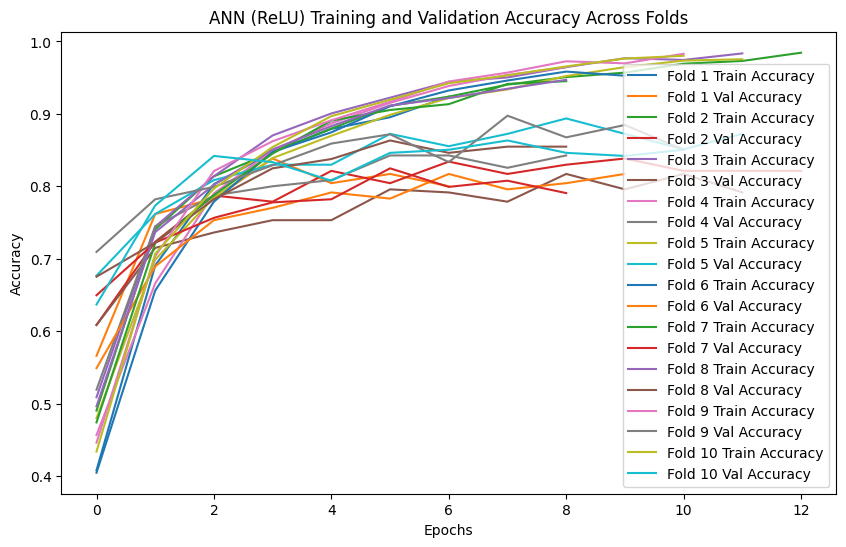

Average Accuracy Across Folds: 0.8496
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8809
Training on Fold 2...
Fold 2 Accuracy: 0.8255
Training on Fold 3...
Fold 3 Accuracy: 0.7915
Training on Fold 4...
Fold 4 Accuracy: 0.8340
Training on Fold 5...
Fold 5 Accuracy: 0.8766
Training on Fold 6...
Fold 6 Accuracy: 0.8298
Training on Fold 7...
Fold 7 Accuracy: 0.8376
Training on Fold 8...
Fold 8 Accuracy: 0.8675
Training on Fold 9...
Fold 9 Accuracy: 0.8632
Training on Fold 10...
Fold 10 Accuracy: 0.8718


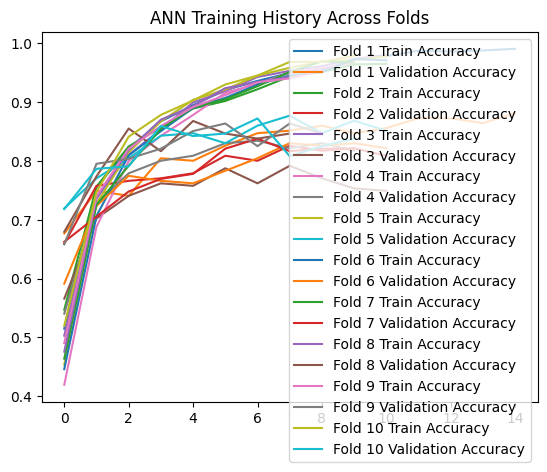

Average Accuracy Across Folds: 0.8478
Results DataFrame created.
Results saved to: result_glove_clean_withIDF_withoutStopWords.csv
Processing file: glove_lemma_withIDF_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.71      0.64      0.67       129
           1       0.56      0.86      0.68       100
           2       0.59      0.53      0.56       118
           3       0.68      0.52      0.59       123

    accuracy                           0.63       470
   macro avg       0.63      0.64      0.62       470
weighted avg       0.64      0.63      0.62       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67       129
           1       0.73      0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8383
Training on Fold 2...
Fold 2 Accuracy: 0.8128
Training on Fold 3...
Fold 3 Accuracy: 0.7702
Training on Fold 4...
Fold 4 Accuracy: 0.8085
Training on Fold 5...
Fold 5 Accuracy: 0.8511
Training on Fold 6...
Fold 6 Accuracy: 0.8213
Training on Fold 7...
Fold 7 Accuracy: 0.7778
Training on Fold 8...
Fold 8 Accuracy: 0.8504
Training on Fold 9...
Fold 9 Accuracy: 0.8590
Training on Fold 10...
Fold 10 Accuracy: 0.8333


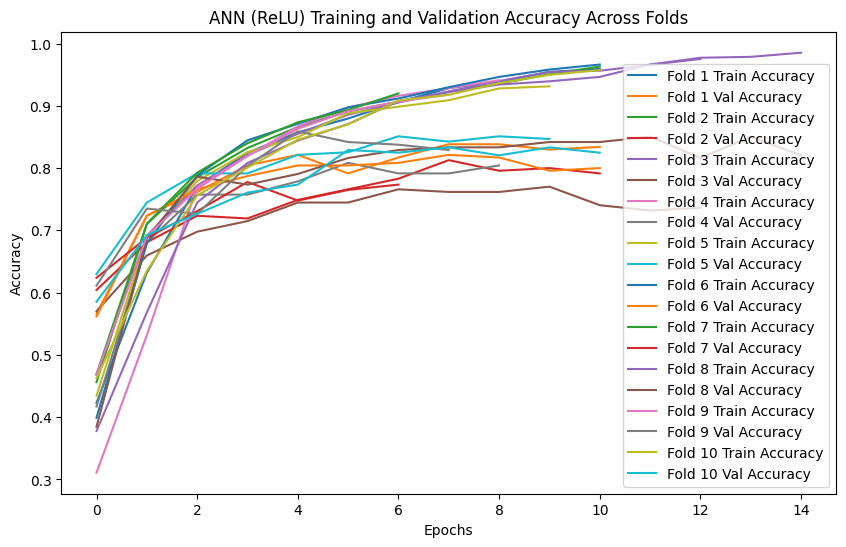

Average Accuracy Across Folds: 0.8223
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8468
Training on Fold 2...
Fold 2 Accuracy: 0.7915
Training on Fold 3...
Fold 3 Accuracy: 0.8043
Training on Fold 4...
Fold 4 Accuracy: 0.8255
Training on Fold 5...
Fold 5 Accuracy: 0.8723
Training on Fold 6...
Fold 6 Accuracy: 0.8298
Training on Fold 7...
Fold 7 Accuracy: 0.7607
Training on Fold 8...
Fold 8 Accuracy: 0.8333
Training on Fold 9...
Fold 9 Accuracy: 0.8205
Training on Fold 10...
Fold 10 Accuracy: 0.8248


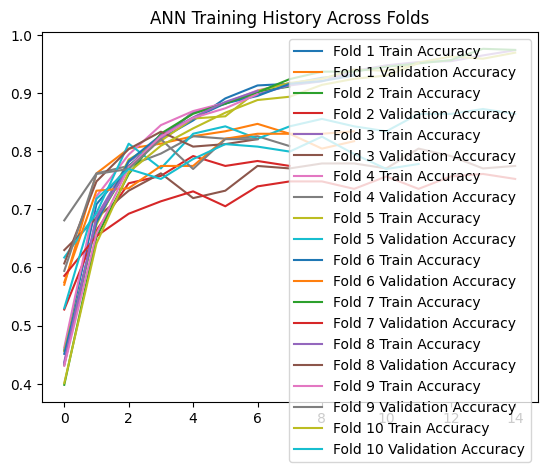

Average Accuracy Across Folds: 0.8210
Results DataFrame created.
Results saved to: result_glove_lemma_withIDF_withStopWords.csv
Processing file: glove_clean_withoutIdf_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       129
           1       0.64      0.87      0.74       100
           2       0.70      0.70      0.70       118
           3       0.82      0.59      0.69       123

    accuracy                           0.76       470
   macro avg       0.76      0.76      0.75       470
weighted avg       0.77      0.76      0.75       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       129
           1       0.84      0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.8894
Training on Fold 2...
Fold 2 Accuracy: 0.8851
Training on Fold 3...
Fold 3 Accuracy: 0.8553
Training on Fold 4...
Fold 4 Accuracy: 0.8638
Training on Fold 5...
Fold 5 Accuracy: 0.9149
Training on Fold 6...
Fold 6 Accuracy: 0.8979
Training on Fold 7...
Fold 7 Accuracy: 0.8846
Training on Fold 8...
Fold 8 Accuracy: 0.9060
Training on Fold 9...
Fold 9 Accuracy: 0.8761
Training on Fold 10...
Fold 10 Accuracy: 0.9231


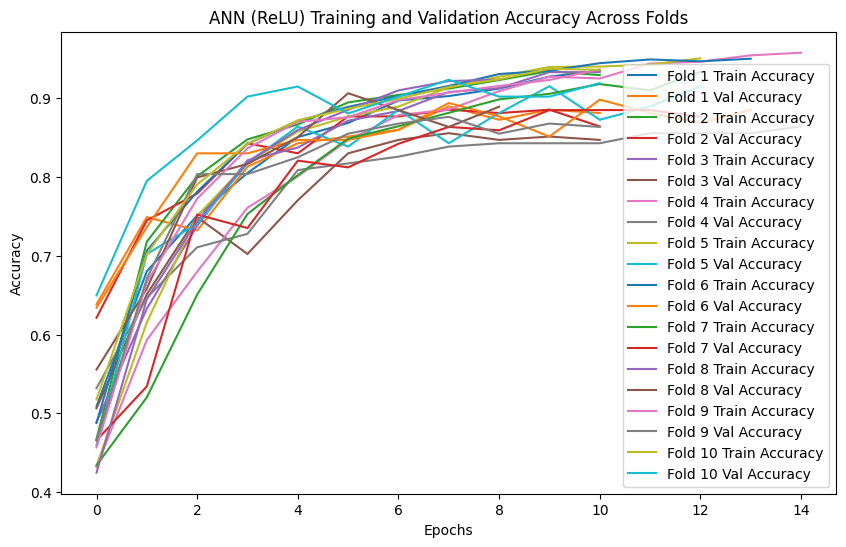

Average Accuracy Across Folds: 0.8896
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8426
Training on Fold 2...
Fold 2 Accuracy: 0.8851
Training on Fold 3...
Fold 3 Accuracy: 0.8511
Training on Fold 4...
Fold 4 Accuracy: 0.8426
Training on Fold 5...
Fold 5 Accuracy: 0.9021
Training on Fold 6...
Fold 6 Accuracy: 0.8638
Training on Fold 7...
Fold 7 Accuracy: 0.8932
Training on Fold 8...
Fold 8 Accuracy: 0.8974
Training on Fold 9...
Fold 9 Accuracy: 0.8974
Training on Fold 10...
Fold 10 Accuracy: 0.9231


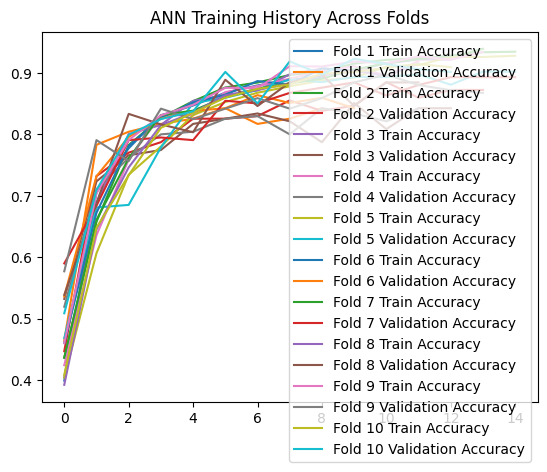

Average Accuracy Across Folds: 0.8798
Results DataFrame created.
Results saved to: result_glove_clean_withoutIdf_withStopWords.csv
Processing file: glove_lemma_withoutIdf_withStopWords.csv
Loading data...
Found 300 dimension columns.
Combined matrix shape: (2346, 300)
Target column shape: (2346,)
Splitting data...
Training classical models...
Training Naive Bayes...
Results for Naive Bayes:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       129
           1       0.66      0.89      0.76       100
           2       0.73      0.72      0.72       118
           3       0.82      0.61      0.70       123

    accuracy                           0.77       470
   macro avg       0.77      0.77      0.76       470
weighted avg       0.78      0.77      0.76       470

Training SVM...
Results for SVM:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75       129
           1       0.81    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.9149
Training on Fold 2...
Fold 2 Accuracy: 0.8596
Training on Fold 3...
Fold 3 Accuracy: 0.8681
Training on Fold 4...
Fold 4 Accuracy: 0.9021
Training on Fold 5...
Fold 5 Accuracy: 0.8894
Training on Fold 6...
Fold 6 Accuracy: 0.8809
Training on Fold 7...
Fold 7 Accuracy: 0.8846
Training on Fold 8...
Fold 8 Accuracy: 0.8889
Training on Fold 9...
Fold 9 Accuracy: 0.9017
Training on Fold 10...
Fold 10 Accuracy: 0.9103


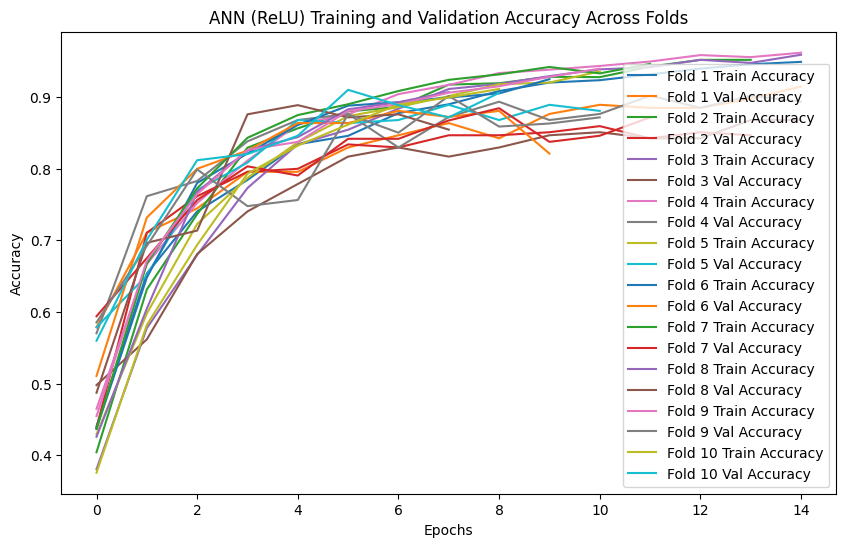

Average Accuracy Across Folds: 0.8900
Training ANN Gelu...
Training on Fold 1...
Fold 1 Accuracy: 0.8851
Training on Fold 2...
Fold 2 Accuracy: 0.8426
Training on Fold 3...
Fold 3 Accuracy: 0.8255
Training on Fold 4...
Fold 4 Accuracy: 0.8723
Training on Fold 5...
Fold 5 Accuracy: 0.9064
Training on Fold 6...
Fold 6 Accuracy: 0.8596
Training on Fold 7...
Fold 7 Accuracy: 0.8419
Training on Fold 8...
Fold 8 Accuracy: 0.9188
Training on Fold 9...
Fold 9 Accuracy: 0.8803
Training on Fold 10...
Fold 10 Accuracy: 0.9017


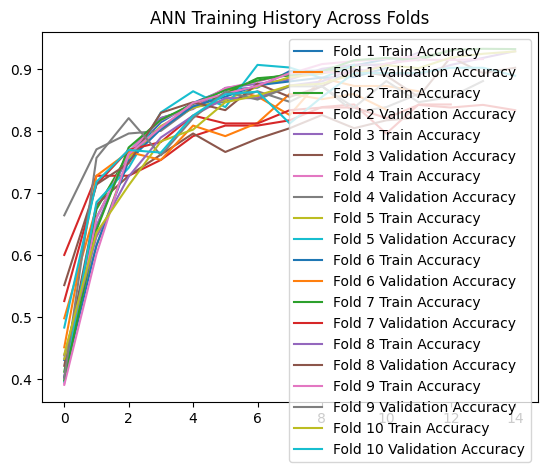

Average Accuracy Across Folds: 0.8734
Results DataFrame created.
Results saved to: result_glove_lemma_withoutIdf_withStopWords.csv
Processing file: result_glove_lemma_withIDF_withoutStopWords.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/glove/result_glove_lemma_withIDF_withoutStopWords.csv: "'Sheet' column not found in the data!"
Error processing file result_glove_lemma_withIDF_withoutStopWords.csv: y should be a 1d array, got an array of shape () instead.
Processing file: result_glove_clean_withoutIdf_withoutStopWords.csv
Loading data...
Found 0 dimension columns.
Combined matrix shape: (32, 0)
Error during processing file /content/drive/MyDrive/Ex2/IR-files/glove/result_glove_clean_withoutIdf_withoutStopWords.csv: "'Sheet' column not found in the data!"
Error processing file result_glove_clean_withoutIdf_withoutStopWords.csv: y should be a 1d array, got an array of shape () instead.
Proc

In [36]:
import os
# הרצת ההרצות
folder_path = "/content/drive/MyDrive/Ex2/IR-files"
process_files_in_folder(folder_path)

In [ ]:
from google.colab import drive

# הרכבת ה-Drive
drive.mount('/content/drive')

# הצגת קבצים ב-Drive
!ls /content/drive/MyDrive


In [ ]:
# Path to the directory
folder_path = "/content/drive/MyDrive/Ex2/IR-files"

# Function to get all CSV files in the directory and its subdirectories
def get_csv_files(path):
    csv_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    return csv_files

# Get all CSV files
csv_files = get_csv_files(folder_path)

# Print the paths of the CSV files
for csv_file in csv_files:
    print(csv_file)


In [ ]:
# דוגמה להרצה על הדוקטוואק בלבד
main("/content/drive/MyDrive/Ex2/IR-files/doc2vec/doc2vec_vectors.csv")